In [3]:
import pandas as pd

RAW_PATH = "../data/raw/google_trends_master.csv"


In [7]:
df = pd.read_csv(RAW_PATH, parse_dates=["date"])
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1765 entries, 0 to 1764
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1765 non-null   datetime64[us]
 1   keyword         1765 non-null   str           
 2   country_code    1765 non-null   str           
 3   interest_score  1765 non-null   int64         
dtypes: datetime64[us](1), int64(1), str(2)
memory usage: 55.3 KB


In [13]:
# Estructure 
print("Shape:",df.shape)
print("\nNull Values\n", df.isnull().sum())
print("\nUnique Countries:\n", df["country_code"].unique())
print("Unique keywoard:", df["keyword"].unique())

Shape: (1765, 4)

Null Values
 date              0
keyword           0
country_code      0
interest_score    0
dtype: int64

Unique Countries:
 <StringArray>
['PE', 'MX', 'CO', 'CL']
Length: 4, dtype: str
Unique keywoard: <StringArray>
[       'billetera digital',                     'Yape',
                     'Plin',                  'fintech',
                 'neobanco',            'criptomonedas',
          'pagos digitales',          'tarjeta virtual',
 'transferencias digitales']
Length: 9, dtype: str


In [15]:
# combination by counting
combo_counts = (
    df.groupby(["country_code", "keyword"])
        .size()
        .reset_index(name="n_obs")
)

combo_counts.sort_values("n_obs")



,country_code,keyword,n_obs
5,CL,pagos digitales,1
16,CO,transferencias digitales,1
7,CL,transferencias digitales,2
25,MX,transferencias digitales,4
31,PE,neobanco,5
22,MX,neobanco,17
19,MX,billetera digital,20
13,CO,neobanco,21
14,CO,pagos digitales,29
32,PE,pagos digitales,30


In [18]:
MIN_MONTHS = 12
valid_combos = combo_counts[combo_counts["n_obs"] >= MIN_MONTHS]

print(f" ANÁLISIS DE FILTRADO:")
print(f"  Total combinaciones: {len(combo_counts)}")
print(f"  Combinaciones con ≥ {MIN_MONTHS} meses: {len(valid_combos)}")
print(f"  Combinaciones descartadas: {len(combo_counts) - len(valid_combos)}")

df_clean = df.merge(
    valid_combos[["country_code", "keyword"]],
    on = ["country_code", "keyword"],
    how = "inner"
)

print(f"\n RESULTADOS:")
print(f"  Registros originales: {len(df)}")
print(f"  Registros después de filtrar: {len(df_clean)}")
print(f"  Reducción: {len(df) - len(df_clean)} registros ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")


 ANÁLISIS DE FILTRADO:
  Total combinaciones: 34
  Combinaciones con ≥ 12 meses: 29
  Combinaciones descartadas: 5

 RESULTADOS:
  Registros originales: 1765
  Registros después de filtrar: 1752
  Reducción: 13 registros (0.7%)


In [ ]:
# Validation
df_clean.groupby(["country_code", "keyword"]).size()

country_code  keyword          
CL            Plin                 73
              Yape                 58
              billetera digital    40
              criptomonedas        73
              fintech              73
              tarjeta virtual      73
CO            Plin                 73
              Yape                 56
              billetera digital    46
              criptomonedas        73
              fintech              73
              neobanco             21
              pagos digitales      29
              tarjeta virtual      73
MX            Plin                 73
              Yape                 69
              billetera digital    20
              criptomonedas        73
              fintech              73
              neobanco             17
              pagos digitales      73
              tarjeta virtual      73
PE            Plin                 73
              Yape                 73
              billetera digital    52
              crip

In [22]:
date_ranges = (
    df_clean.groupby(["country_code", "keyword", "date"])
            .agg([min, max])
            .reset_index()
)

date_ranges.head()

country_code keyword       date interest_score    
                                             min max
0           CL    Plin 2019-01-01             18  18
1           CL    Plin 2019-02-01             21  21
2           CL    Plin 2019-03-01             20  20
3           CL    Plin 2019-04-01             18  18
4           CL    Plin 2019-05-01             17  17

In [23]:
global_max = df_clean["date"].max()
global_min = df_clean["date"].min()


In [24]:
df_clean = df_clean[
    (df_clean["date"] >= df_clean["date"].min()) &
    (df_clean["date"] <= df_clean["date"].max())
]

In [25]:
df_clean.describe()

,date,interest_score
count,1752,1752.000000
mean,2022-03-11 19:17:15.616438,47.121005
min,2019-01-01 00:00:00,1.000000
25%,2020-10-01 00:00:00,27.000000
50%,2022-05-01 00:00:00,45.000000
75%,2023-09-01 00:00:00,66.000000
max,2025-01-01 00:00:00,100.000000
std,NaN,24.615749


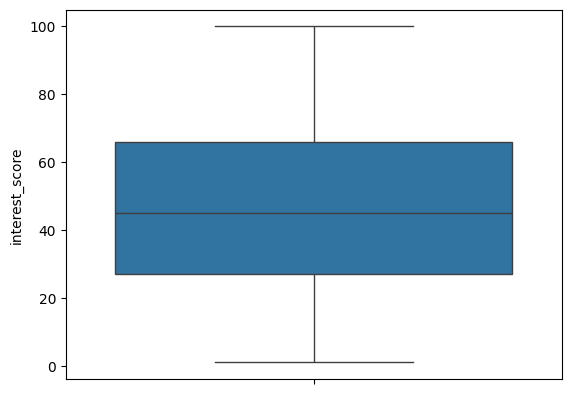

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_clean["interest_score"])
plt.show()


In [ ]:
# Z-score calculation
df_clean["z_score"] = (
    df_clean.groupby(["country_code", "keyword"])["interest_score"]
            .transform(lambda x: (x - x.mean()) / x.std())
)

In [31]:
PROCESSED_PATH = "../data/processed/google_trends_clean.csv" 

df_clean.to_csv(PROCESSED_PATH, index=False) 